In [ ]:
# Dataset Link: https://www.kaggle.com/datasets/deepcontractor/is-that-santa-image-classification
# [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [ ]:
# Step by Step Approach
# 1. Import libraries
# 2. Load Data
# 3. Build Model
# 4. Train & Evaluate the Model

# Step 1: Import Libraries & Set Processing Device


In [3]:
# Libraries

import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 2: Load Data
#### A. Data Transformer
#### B. Create Dataset
#### C. Data Loader

In [6]:
# Data Transformer
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# Create Dataset
TRAIN_ROOT = "is that santa/train"
TEST_ROOT = "is that santa/test"

train_ds = ImageFolder(TRAIN_ROOT, transform=tfm)
test_ds = ImageFolder(TEST_ROOT, transform=tfm)

In [8]:
# Length of Train and Test Datasets
LEN_TRAIN = len(train_ds)
LEN_TEST = len(test_ds)
print(LEN_TRAIN, LEN_TEST)

# Index Mapping
print(train_ds.class_to_idx)

614 616
{'not-a-santa': 0, 'santa': 1}


In [9]:
# Data Loader
train_loader = DataLoader(train_ds, batch_size = 30, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=30, shuffle = True)

# Step 3: Build Model, Optimiser and Loss Function

In [12]:
# Model
model = resnet18(pretrained=True)

# Replace Output of Fully Connected Layer with Number of Labels for our Classification Problem
model.fc = Linear(in_features=512, out_features=2)
model = model.to(device)
# model = model.cuda()    # only if your system supports Nvidia CUDA

In [13]:
# Optimiser
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

# Loss Function
loss_fn = CrossEntropyLoss()

# Step 4: Train & Evaluate the Model


In [25]:
for epoch in range(3):
    start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            
            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimiser.step()
            
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / LEN_TRAIN
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        for xtest, ytest in test_loader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
            
        ep_test_acc = test_acc / LEN_TEST
    
    end = time()
    duration = (end - start) / 60
    
    print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Test_acc: {ep_test_acc}")

100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [00:12<00:00,  1.68batch/s]


Epoch: 0, Time: 0.3995072682698568, Loss: 0.33908572793006897
Train_acc: 0.8990228013029316, Test_acc: 0.9318181818181818


100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [00:11<00:00,  1.80batch/s]


Epoch: 1, Time: 0.39139344294865924, Loss: 0.07737012207508087
Train_acc: 0.9690553745928339, Test_acc: 0.9577922077922078


100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [00:12<00:00,  1.69batch/s]


Epoch: 2, Time: 0.4114218910535177, Loss: 0.04488289728760719
Train_acc: 0.990228013029316, Test_acc: 0.961038961038961


# Model Performance on Samples

In [26]:
# Image Samples
sample_1 = 'is that santa/test/santa/283.Santa.jpg'
sample_2 = 'is that santa/test/santa/474.Santa.jpg'
sample_3 = 'is that santa/test/not-a-santa/340.not-a-santa.jpg'
sample_4 = 'is that santa/test/not-a-santa/58.not-a-santa.jpg'

sample_list = [sample_1,sample_2,sample_3,sample_4]

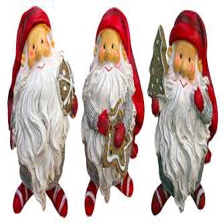

Model prediction 1, hence Santa


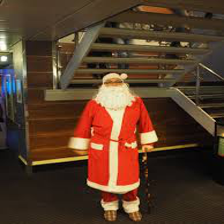

Model prediction 1, hence Santa


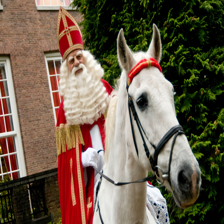

Model prediction 1, hence Santa


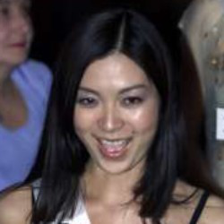

Model prediction 0, hence Not Santa


In [40]:
# Model Performance
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = Image.open(image_path)
    display(img.resize((224,224)))
    img_tensor = tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    if pred == 1:
        print(f"Model prediction {pred}, hence Santa")
    else:
        print(f"Model prediction {pred}, hence Not Santa")

    print("========================================================")